# Transformers Lab: Pre. OUHMIDA Asmae
### EMSI 2025/2026

### 1 Importation des bibliothèques

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
print(tf.version)

<module 'tensorflow._api.v2.version' from 'C:\\Users\\uzi\\Desktop\\deeplearning\\.venv\\Lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


### 2.Charger un ensemble de données de commentaires avec des étiquettes de sentiments (positif ou négatif). Diviser l'ensemble de données en ensembles d'entraînement et de test

In [25]:
# Charger les données (exemple avec le jeu de données IMDB)
(train_texts,train_labels),(test_texts,test_labels)=keras.datasets.imdb.load_data(num_words=1000)

In [27]:
train_texts

array([list([1, 14, 22, 16, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 2, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]),
       list([1, 194, 2, 194, 2, 78, 228, 5, 6, 2, 2, 2, 134, 26, 4, 715, 8, 118, 2, 14, 394, 20, 13, 119, 954, 189,

### 3.Convert sequences to texts

In [28]:
word_index = tf.keras.datasets.imdb.get_word_index()

In [29]:
reverse_word_index =dict([(value,key) for ( key, value) in word_index.items()])

In [30]:
train_texts =[' '.join([reverse_word_index.get(i -3,'?') for i in seq ]) for seq in train_texts]

In [31]:
test_texts =[' '.join([reverse_word_index.get(i -3,'?') for i in seq ]) for seq in test_texts]

In [32]:
# Preprocess text data
max_length =256
tokenizer = Tokenizer(num_words=10000,oov_token='<OOV>')

tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

train_padded = pad_sequences(train_sequences,maxlen=max_length,padding='post',truncating='post')
test_padded = pad_sequences(test_sequences,maxlen=max_length,padding='post',truncating='post')

### Build the Transformer Model

In [9]:
!pip install tensorflow-addons

ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [33]:

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D

import matplotlib.pyplot as plt

# Define the Transformer block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu'),
            Dense(dff, activation='relu'),
            Dense(dff, activation='relu'),
            Dense(embed_dim) ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    def call(self, inputs):
        attn_output =  self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output,)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, )
        return self.layernorm2(out1 + ffn_output)


embedding_dim = 64
num_heads = 8
dff = 128
model = Sequential([ Embedding(input_dim=10000, output_dim=embedding_dim, input_length=max_length),
TransformerBlock(embed_dim=embedding_dim, num_heads=num_heads, dff=dff),
GlobalAveragePooling1D(),
#Bidirectional(LSTM(64)),
Dense(1, activation='sigmoid')])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 256, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding             │ (None, 256, 128)       │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 256, 128)       │       659,712 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 256, 128)       │       659,712 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ (None, 256, 128)       │       659,712 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,457 (12.46 MB)

 Trainable params: 3,267,457 (12.46 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Transformer Model

In [34]:
epochs =2
batch_size =32
history=model.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_padded, test_labels))

Epoch 1/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 2445s 3s/step - accuracy: 0.5022 - loss: 0.6966 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/2
102/782 ━━━━━━━━━━━━━━━━━━━━ 27:07 2s/step - accuracy: 0.4993 - loss: 0.6931

KeyboardInterrupt: 

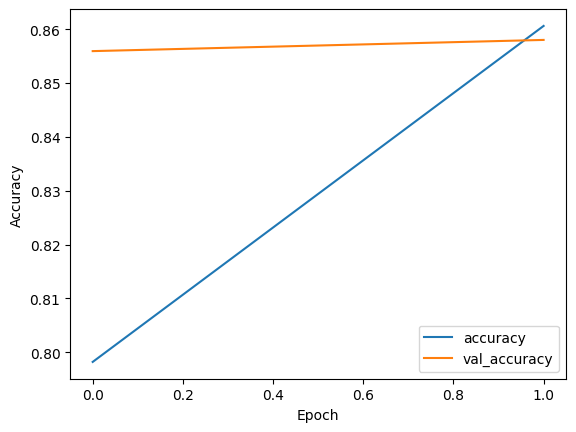

In [12]:

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [13]:
predictions = model.predict(test_padded)

782/782 ━━━━━━━━━━━━━━━━━━━━ 131s 167ms/step


In [14]:
import numpy as np
print(predictions[3])
print(test_labels[3])

[0.37040418]
0


In [15]:

# Evaluate the model on the test set
evaluation = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {evaluation[1] *100:.2f}%")


782/782 ━━━━━━━━━━━━━━━━━━━━ 79s 100ms/step - accuracy: 0.8616 - loss: 0.3204
Test Accuracy: 86.16%


In [16]:
# after improving its accuracy save the entire model to a file
model.save("transformer_model.h5")